## 分析A/B测试结果

我们设计项目的初衷是希望让它涵盖统计课程里所有的内容，所以项目会有难度。如果你进行不顺利，不用着急，你可以回顾以前课程中的内容，或者寻求帮助。如果你成功完成项目，代表你已掌握这部分内容。祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

A/B 测试是数据分析师和数据科学家需要经常完成的工作，非常重要。如果你在工作中有一些实践经验，那学习起来就会更加游刃有余。

本项目设定了一家电子商务网站运行 A/B 测试的情境。你的目标是通过这个项目来帮助公司分析和决定他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**注意，有些题目会提醒你先做课堂页面的测试问题，这些测试会提供答案，可以给你提供一些帮助。** 最后做完项目时记得检查，确保提交内容符合[审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 。

<a id='probability'></a>
#### I - 概率

先导入数据。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  你可以直接进行以下问题的回答，或者 **做教室里的测试 1** 。

a. 导入数据集，查看前几行数据：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查看数据集的行数。

In [3]:
df.shape[0]

294478

c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df['user_id'].nunique()

290584

d. 转化用户的占比。

In [5]:
df['converted'].mean()

0.11965919355605512

e. 请计算数据中 `new_page` 与 `treatment` 不匹配的次数。提示：在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893


f. 是否有任何行空缺数值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是否接收到了新页面还是旧页面。如何处理这些行？你可以返回教室里的页面先做 **测试 2** 。  

a. 现在，参照测试2的答案去创建一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 根据 **df2** 来回答以下问题，或者做教室里的 **测试3** 。

a.  **df2** 中的用户数量（不同的 **user_id**) ?

In [10]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？

In [11]:
df2[df2.duplicated('user_id')]['user_id']

2893    773192
Name: user_id, dtype: int64

c. 这个重复  **user_id** 的行信息是什么？

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除一行重复行，但仍然存储 dataframe 为 **df2**。

In [13]:
df2 = df2.drop_duplicates('user_id')

`4.` 使用优化过的 **df2** 来回答以下问题，或者做 **测试 4**。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

In [14]:
df2['converted'].mean()

0.11959708724499628

b. `control` 组用户的转化率是多少？

In [15]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. `treatment` 组用户的转化率是多少？

In [16]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. 一个用户收到新页面的概率是多少？

In [17]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？

**在这里写出你的答案。**

不能。

<a id='ab_test'></a>
### II - A/B 测试

因为每个事件都对应有一个时间记录（time stamp 时间戳），所以技术上你可以实现每次观察都连续运行假设检验。

然而，问题的难点在于，什么时候停止你的试验：是在发现其中一组的试验效果足够好时立即停止？还是在这样的观察结果又持续发生了一段时间再停止？需要运行多长时间才能确认两个页面没有带来用户转化率的显著差异？

这些问题是 A/B 测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你需要根据我们提供的数据做出决策：你假设旧页面效果更佳，除非在一类错误在5%以内，新页面被证明更好。基于此，你的零假设和备择假设是什么？ 你可以用文字表述或用 **$p_{old}$** 与 **$p_{new}$** （即，旧页面转化率与新页面转化率）来陈述你的假设。

**H0:新页面转化率小于等于旧页面转化率；H1：新页面转化率大于旧页面转化率。**

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，我们还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。记住，每个页面的样本大小要与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>

使用下面的单元格提供这个模拟试验的内容。如果不太理解如何进行模拟，不要担心，你可以通过回答下面的问题来理清思路。同时，你可以在教室里的 **测试 5** 里验证你的答案是否正确。<br>

a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [20]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d.  $n_{old}$?是多少？

In [21]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [22]:
random.seed(42)
new_page_converted = np.random.choice(2,size = n_new,p = [1-p_new,p_new])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [23]:
old_page_converted = np.random.choice(2,size = n_old,p = [1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [24]:
p_diff = new_page_converted.mean() - old_page_converted.mean()

h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [25]:
p_diffs = []
for _ in range(10000):
    p_new_page_converted = np.random.choice(2,size = n_new,p = [1-p_new,p_new]).mean()
    p_old_page_converted = np.random.choice(2,size = n_old,p = [1-p_old,p_old]).mean()
    p_diffs.append(p_new_page_converted - p_old_page_converted)

i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

(array([   19.,   163.,   690.,  1822.,  2837.,  2504.,  1449.,   428.,
           78.,    10.]),
 array([-0.00433832, -0.00344012, -0.00254193, -0.00164373, -0.00074554,
         0.00015265,  0.00105085,  0.00194904,  0.00284724,  0.00374543,
         0.00464363]),
 <a list of 10 Patch objects>)

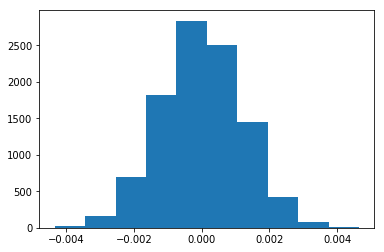

In [26]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [27]:
obs_diff = df2.query('landing_page == "new_page"')['converted'].mean() - df2.query('landing_page == "old_page"')['converted'].mean()
(p_diffs > obs_diff).mean()

0.9032

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

**该值为p值，p值为0.9032大于0.025，不能拒绝原假设。**


l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group =="control" and converted == 1').shape[0]
convert_new = df2.query('group =="treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. 现在使用 `stats.proportions_ztest` 来计算你的 z-score (什么是 [z-score](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)) 与 p-value。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 的资料可以提供额外信息。

In [29]:
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
z_score,p_value

(1.3109241984234394, 0.90505831275902449)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？

**结果是一致的。z值为1.311，经查表可知临界值为1.645，1.311<1.645,因此无法拒绝零假设。**

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**逻辑回归**

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [30]:
import statsmodels.api as sm
df2[['ab_page1','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page1',axis=1)
df2['intercept'] = 1


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [31]:
logi = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
logi_results = logi.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [32]:
logi_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:00:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**p值为0.190，在第二部分中p值为0.9032，两个p值不同的原因是因为检验方式不同，第二部分中使用的是单尾检验，零假设为旧页面转化率比新页面的转化率高或者相同，而在此处的零假设为页面的新旧与转化率无关，备择假设为页面的新旧与转化率有关，p值为0.190>0.05,因此，经检验得知，ab_page不适合用于预测转化率。**

f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在实际应用中，总是会有其他因素对响应变量有着一定的影响，将其他元素添加到回归模型中，会提升模型整体的拟合效度，从而更好地进行分析。 而过多地添加附加项，会造成错误的推论，例如变量和变量之间可能有着共线性，从而影响整体的结论。。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [34]:
df3 = pd.read_csv('countries.csv')
df3 = df2.merge(df3,on='user_id')
df3['country'].unique()
df3.head(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [35]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('US',axis = 1)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0


In [36]:
df3['intercept']=1
logit_mod=sm.Logit(df3.converted,df3[['intercept','ab_page','CA','UK']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 07 Sep 2019   Pseudo R-squ.:               2.323e-05
Time:                        08:25:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

从p值来看，CA和UK的p值均大于0.05，国家这一项并不具备统计显著性，对转化率影响并不大。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [37]:
df3['new_CA'] = df3['ab_page'] * df3['CA']
df3['new_UK'] = df3['ab_page'] * df3['UK']

In [40]:
df3['intercept']=1
logit_mod=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','new_CA','UK','new_UK']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Sep 2019   Pseudo R-squ.:               3.482e-05
Time:                        08:27:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

从上面的逻辑回归结果来看，p值均大于0.05，说明国家和页面的相互作用，对转化率也没有显著影响。

总结：
以目前的假设检验结果来看，没有结果能证明新旧页面的应用与转化率有着一定的关系，如若需要确定结果，需要重新进行测试或者延长测试时间，才能确定使用新页面，或者仍使用旧页面。

<a id='conclusions'></a>
## 总结

祝贺你完成了该项目！

### 收集提交材料

如果不再修改notebook，将它保存为便于其他人阅读并查看的格式。你可以使用 __File -> Download as -> HTML (.html)__ 菜单将你的 Notebook 保存为一个 .html 文件。如果你在本地操作，遇到 "找不到模块名称（No module name）" 错误，请打开终端并尝试使用 `pip install <module_name>` 安装缺少的模块。

你需要同时提交原始 Notebook 和 Notebook 的HTML或PDF副本以供审阅。你不需要在提交中附带任何数据文件。如果你参考了其他网站、书籍和其他资源来帮助你解决项目中的任务，请确保记录在项目里。建议你在 Notebook报告末尾的 Markdown 单元格中添加 “Resources” 部分，或者可以附带一个记录你的参考资源的 `readme.txt` 文件。


### 提交项目

准备就绪后，点击“提交项目”按钮进入项目提交页面。你可以将文件以 .zip压缩文件提交，也可以链接到包含项目文件的 GitHub 仓库。如果你使用的是 GitHub，请注意，你提交的内容将是提交时的链接库的一个快照。建议你将每个项目都保存在单独的仓库里，以避免出现混淆。

我们会在一周或者更短的时间对项目进行审阅。项目被审阅后，你会收到一封电子邮件。如果你在提交项目时遇到任何问题，或者想要查看提交状态，请发送电子邮件至 support@youdaxue.com。